In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import sqlalchemy
import pickle

from plot_utility import *

USER = "jialeiwang"
PASSWORD = "wangjialei123"
HOST = "work.cxcjqzn7ydtp.us-east-1.rds.amazonaws.com"
DB = "sfp_AcpS"
engine = sqlalchemy.create_engine("mysql+pymysql://{0}:{1}@{2}/{3}".format(USER, PASSWORD, HOST, DB))

In [ ]:
plt.style.use('grayscale')

In [ ]:
with open("visualization_coord", "rb") as f:
    visualization_data = pickle.load(f)

In [ ]:
# simulations study for sfp orthogonal

<IPython.core.display.Javascript object>


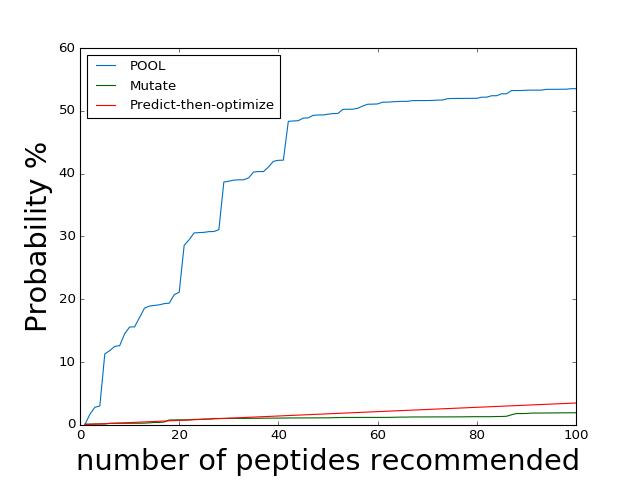

In [3]:
plot_benchmark(pd.read_sql_table("benchmark_sfp_orthogonal", engine), fig_path="/Users/jialeiwang/Documents/benchmark_sfp_orth")

In [ ]:
plot_coord(visualization_data, "sfp_orthogonal", fig_path="/Users/jialeiwang/Documents/visual_sfp_orth")

In [ ]:
# simulation study for AcpS orthogonal

<IPython.core.display.Javascript object>


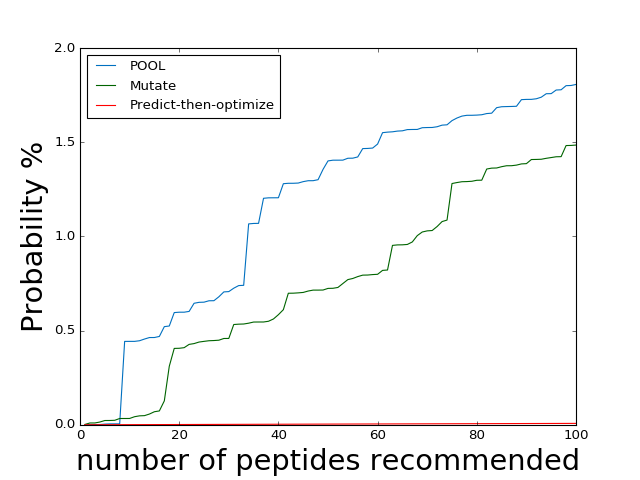

In [2]:
plot_benchmark(pd.read_sql_table("benchmark_AcpS_orthogonal", engine), fig_path="/Users/jialeiwang/Documents/benchmark_AcpS_orth")

In [ ]:
plot_coord(visualization_data, "AcpS_orthogonal", fig_path="/Users/jialeiwang/Documents/visual_AcpS_orth")

In [ ]:
#ROC for sfp
plot_roc(pd.read_sql_table("ROC_sfp", engine))

In [ ]:
#ROC for AcpS
plot_roc(pd.read_sql_table("ROC_AcpS", engine))

In [ ]:
#ROC for AcpH
plot_roc(pd.read_sql_table("ROC_PfAcpH", engine))

In [ ]:
# find sfp_type, but measure performance using the criterion "sfp orthogonal"
plot_benchmark(pd.read_sql_table("benchmark_type1", engine))

In [ ]:
# find AcpS_type, but measure performance using the criterion "AcpS orthogonal"
plot_benchmark(pd.read_sql_table("benchmark_type2", engine))

In [ ]:
# Below is to produce heatmaps for analyzing thetas

In [ ]:
data = pd.read_sql_table("binary_labeling_activity", engine)

In [ ]:
def init_counting(coef, rownames):
    n = 19
    colnames = np.concatenate((['L'+str(i) for i in range(n,0, -1)], ['R'+str(i) for i in range(1,n+1)]))
    one_row = np.concatenate((np.sqrt(np.arange(n,0,-1)), np.sqrt(np.arange(1,n+1)))).reshape((1,-1))
    vals = coef * np.repeat(one_row, len(rownames), axis=0)
    df = pd.DataFrame(vals, index=rownames, columns=colnames)
    return df

def counting(data, colnames, target_vals, mapping, count):
    n = 19
    count = count.copy()
    new_data = data.copy()
    for i, colname in enumerate(colnames):
        new_data = new_data.loc[new_data[colname] == target_vals[i], :]
    for index, row in new_data.iterrows():
        len_l = len(row['nterm'])
        len_r = len(row['cterm'])
        if len_l > 0 and len_r > 0:
            for i, c in enumerate(row['nterm']):
                if (len_l-i) <= n:
                    count.loc[mapping[c], 'L'+str(len_l-i)] += 1
            for i, c in enumerate(row['cterm']):
                if (i+1) <= n:
                    count.loc[mapping[c], 'R'+str(i+1)] += 1
    return count

def compute_prob(peptide_df, count_1, count_0, p1, num_mc, mapping):
    n = 19
    prob = np.ones((len(peptide_df), num_mc)) * np.log((1.-p1)/p1)
    theta_1_dict = {}
    theta_0_dict = {}
    for colname in count_1.columns:
        theta_1_dict[colname] = np.log(np.random.dirichlet(count_1.loc[:, colname], num_mc))
        theta_0_dict[colname] = np.log(np.random.dirichlet(count_0.loc[:, colname], num_mc))
    for i, idx in enumerate(peptide_df.index):
        len_l = len(peptide_df.loc[idx, 'nterm'])
        for j, a in enumerate(peptide_df.loc[idx, 'nterm']):
            prob[i, :] += theta_0_dict['L'+str(len_l-j)][:, mapping[a]-1]
            prob[i, :] -= theta_1_dict['L'+str(len_l-j)][:, mapping[a]-1]
        for j, a in enumerate(peptide_df.loc[idx, 'cterm']):
            prob[i, :] += theta_0_dict['R'+str(j+1)][:, mapping[a]-1]
            prob[i, :] -= theta_1_dict['L'+str(j+1)][:, mapping[a]-1]
    prob = 1. / (1. + np.exp(prob))
    ret = pd.DataFrame()
    ret['sequence'] = peptide_df['sequence']
    ret['prob'] = np.mean(prob, axis=1)
    return ret

def summarize_stats(df_list, func, num_mc):
    result_mean = df_list[0].copy()
    result_sd = df_list[0].copy()
    result_stat = df_list[0].copy()
    for col in df_list[0].columns:
        samples_list = []
        for df in df_list:
            samples_list.append(np.random.dirichlet(df.loc[:, col], num_mc))
        processed_sample = func(samples_list)
        sample_mean = np.mean(processed_sample, axis=0)
        sample_sd = np.std(processed_sample, axis=0)
        result_mean.loc[:, col] = sample_mean
        result_sd.loc[:, col] = sample_sd
        result_stat.loc[:, col] = sample_mean / sample_sd
    return result_mean, result_sd, result_stat

def stat_test_orth(df_l1, df_l0, df_n1, df_n0, num_mc):
    prob = df_l1.copy()
    for col in df_l1.columns:
        samples_l1 = np.random.dirichlet(df_l1.loc[:, col], num_mc)
        samples_l0 = np.random.dirichlet(df_l0.loc[:, col], num_mc)
        samples_n1 = np.random.dirichlet(df_n1.loc[:, col], num_mc)
        samples_n0 = np.random.dirichlet(df_n0.loc[:, col], num_mc)
        truth_table = (samples_l1 > samples_l0) & (samples_n1 < samples_n0)
        prob.loc[:, col] = np.mean(truth_table, axis=0)
    return prob

def stat_test_labeling(df_1, df_0, num_mc):
    prob = df_1.copy()
    for col in df_1.columns:
        samples_1 = np.random.dirichlet(df_1.loc[:, col], num_mc)
        samples_0 = np.random.dirichlet(df_0.loc[:, col], num_mc)
        truth_table = samples_1 > samples_0
        prob.loc[:, col] = np.mean(truth_table, axis=0)
    return prob

In [ ]:
fine_map = {'A':'A', 'R':'R', 'N':'N', 'D':'D', 'C':'C', 'Q':'Q', 'E':'E', 'G':'G', 'H':'H', 'I':'I', 'L':'L', 
           'K':'K', 'M':'M', 'F':'F', 'P':'P', 'S':'S', 'T':'T', 'W':'W', 'Y':'Y', 'V':'V'}
fine_rownames = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
reduced_map = {'A':5, 'R':4, 'N':2, 'D':1, 'C':8, 'Q':2, 'E':1, 'G':6, 'H':4, 'I':5, 'L':5, 
           'K':4, 'M':5, 'F':3, 'P':6, 'S':7, 'T':7, 'W':3, 'Y':3, 'V':5}
reduced_rownames = range(1,9)

In [ ]:
# logratio for reduced map
init_count = init_counting(10., reduced_rownames)
sfp_count_1 = counting(data, ['sfp'], [1], reduced_map, init_count)
sfp_count_0 = counting(data, ['sfp'], [0], reduced_map, init_count)
AcpS_count_1 = counting(data, ['AcpS'], [1], reduced_map, init_count)
AcpS_count_0 = counting(data, ['AcpS'], [0], reduced_map, init_count)
func_logratio = lambda x: np.log(x[0]) - np.log(x[1]) - np.log(x[2]) + np.log(x[3])
logratio_mean, logratio_sd, logratio_stat = summarize_stats([sfp_count_1, sfp_count_0, AcpS_count_1, AcpS_count_0], func_logratio, 10000)
writer = pd.ExcelWriter("/Users/jialeiwang/Documents/ucsd_heatmap/logratio_reduced.xls", engine = 'xlwt')
logratio_stat.to_excel(writer, sheet_name = "stat")
logratio_mean.to_excel(writer, sheet_name = "mean")
logratio_sd.to_excel(writer, sheet_name = "sd")
writer.save()

In [ ]:
# logratio labeling for reduced map
init_count = init_counting(10., reduced_rownames)
sfp_count_1 = counting(data, ['sfp'], [1], reduced_map, init_count)
sfp_count_0 = counting(data, ['sfp'], [0], reduced_map, init_count)
AcpS_count_1 = counting(data, ['AcpS'], [1], reduced_map, init_count)
AcpS_count_0 = counting(data, ['AcpS'], [0], reduced_map, init_count)
func_logratio = lambda x: np.log(x[0]) - np.log(x[1])
sfp_logratio_mean, sfp_logratio_sd, sfp_logratio_stat = summarize_stats([sfp_count_1, sfp_count_0], func_logratio, 10000)
AcpS_logratio_mean, AcpS_logratio_sd, AcpS_logratio_stat = summarize_stats([AcpS_count_1, AcpS_count_0], func_logratio, 10000)
writer = pd.ExcelWriter("/Users/jialeiwang/Documents/ucsd_heatmap/logratio_labeling_reduced.xls", engine = 'xlwt')
sfp_logratio_stat.to_excel(writer, sheet_name = "sfp stat")
AcpS_logratio_stat.to_excel(writer, sheet_name = "AcpS stat")
sfp_logratio_mean.to_excel(writer, sheet_name = "sfp mean")
AcpS_logratio_mean.to_excel(writer, sheet_name = "AcpS mean")
sfp_logratio_sd.to_excel(writer, sheet_name = "sfp sd")
AcpS_logratio_sd.to_excel(writer, sheet_name = "AcpS sd")
writer.save()

In [ ]:
# logratio for fine map
init_count = init_counting(10., fine_rownames)
sfp_count_1 = counting(data, ['sfp'], [1], fine_map, init_count)
sfp_count_0 = counting(data, ['sfp'], [0], fine_map, init_count)
AcpS_count_1 = counting(data, ['AcpS'], [1], fine_map, init_count)
AcpS_count_0 = counting(data, ['AcpS'], [0], fine_map, init_count)
func_logratio = lambda x: np.log(x[0]) - np.log(x[1]) - np.log(x[2]) + np.log(x[3])
logratio_mean, logratio_sd, logratio_stat = summarize_stats([sfp_count_1, sfp_count_0, AcpS_count_1, AcpS_count_0], func_logratio, 10000)
writer = pd.ExcelWriter("/Users/jialeiwang/Documents/ucsd_heatmap/logratio_fine.xls", engine = 'xlwt')
logratio_stat.to_excel(writer, sheet_name = "stat")
logratio_mean.to_excel(writer, sheet_name = "mean")
logratio_sd.to_excel(writer, sheet_name = "sd")
writer.save()

In [ ]:
# logratio labeling for fine map
init_count = init_counting(10., fine_rownames)
sfp_count_1 = counting(data, ['sfp'], [1], fine_map, init_count)
sfp_count_0 = counting(data, ['sfp'], [0], fine_map, init_count)
AcpS_count_1 = counting(data, ['AcpS'], [1], fine_map, init_count)
AcpS_count_0 = counting(data, ['AcpS'], [0], fine_map, init_count)
func_logratio = lambda x: np.log(x[0]) - np.log(x[1])
sfp_logratio_mean, sfp_logratio_sd, sfp_logratio_stat = summarize_stats([sfp_count_1, sfp_count_0], func_logratio, 10000)
AcpS_logratio_mean, AcpS_logratio_sd, AcpS_logratio_stat = summarize_stats([AcpS_count_1, AcpS_count_0], func_logratio, 10000)
writer = pd.ExcelWriter("/Users/jialeiwang/Documents/ucsd_heatmap/logratio_labeling_fine.xls", engine = 'xlwt')
sfp_logratio_stat.to_excel(writer, sheet_name = "sfp stat")
AcpS_logratio_stat.to_excel(writer, sheet_name = "AcpS stat")
sfp_logratio_mean.to_excel(writer, sheet_name = "sfp mean")
AcpS_logratio_mean.to_excel(writer, sheet_name = "AcpS mean")
sfp_logratio_sd.to_excel(writer, sheet_name = "sfp sd")
AcpS_logratio_sd.to_excel(writer, sheet_name = "AcpS sd")
writer.save()

In [ ]:
# count hits using fine map
init_count = init_counting(0., fine_rownames)
sfp_orth_count = counting(data, ['sfp', 'AcpS'], [1, 0], fine_map, init_count)
AcpS_orth_count = counting(data, ['sfp', 'AcpS'], [0, 1], fine_map, init_count)
sfp_count = counting(data, ['sfp'], [1], fine_map, init_count)
AcpS_count = counting(data, ['AcpS'], [1], fine_map, init_count)
writer = pd.ExcelWriter("/Users/jialeiwang/Documents/ucsd_heatmap/raw_counts_fine.xls", engine = 'xlwt')
sfp_orth_count.to_excel(writer, sheet_name = "sfp orthogonal")
AcpS_orth_count.to_excel(writer, sheet_name = "AcpS orthogonal")
sfp_count.to_excel(writer, sheet_name = "sfp labeling")
AcpS_count.to_excel(writer, sheet_name = "AcpS labeling")
writer.save()

In [ ]:
# count hits using reduced map
init_count = init_counting(0., reduced_rownames)
sfp_orth_count = counting(data, ['sfp', 'AcpS'], [1, 0], reduced_map, init_count)
AcpS_orth_count = counting(data, ['sfp', 'AcpS'], [0, 1], reduced_map, init_count)
sfp_count = counting(data, ['sfp'], [1], reduced_map, init_count)
AcpS_count = counting(data, ['AcpS'], [1], reduced_map, init_count)
# writer = pd.ExcelWriter("/Users/jialeiwang/Documents/ucsd_heatmap/raw_counts_reduced.xls", engine = 'xlwt')
# sfp_orth_count.to_excel(writer, sheet_name = "sfp orthogonal")
# AcpS_orth_count.to_excel(writer, sheet_name = "AcpS orthogonal")
# sfp_count.to_excel(writer, sheet_name = "sfp labeling")
# AcpS_count.to_excel(writer, sheet_name = "AcpS labeling")
# writer.save()

In [ ]:
# compute prob_stat using fine map
init_count = init_counting(10., fine_rownames)
sfp_count_1 = counting(data, ['sfp'], [1], fine_map, init_count)
sfp_count_0 = counting(data, ['sfp'], [0], fine_map, init_count)
AcpS_count_1 = counting(data, ['AcpS'], [1], fine_map, init_count)
AcpS_count_0 = counting(data, ['AcpS'], [0], fine_map, init_count)
sfp_prob_stat = stat_test_orth(sfp_count_1, sfp_count_0, AcpS_count_1, AcpS_count_0, 100000)
AcpS_prob_stat = stat_test_orth(AcpS_count_1, AcpS_count_0, sfp_count_1, sfp_count_0, 100000)
sfp_labeling_stat = stat_test_labeling(sfp_count_1, sfp_count_0, 100000)
AcpS_labeling_stat = stat_test_labeling(AcpS_count_1, AcpS_count_0, 100000)
writer = pd.ExcelWriter("/Users/jialeiwang/Documents/ucsd_heatmap/prob_test_fine.xls", engine = 'xlwt')
sfp_prob_stat.to_excel(writer, sheet_name = "sfp orth")
AcpS_prob_stat.to_excel(writer, sheet_name = "AcpS orth")
sfp_labeling_stat.to_excel(writer, sheet_name = "sfp labeling")
AcpS_labeling_stat.to_excel(writer, sheet_name = "AcpS labeling")
writer.save()

In [ ]:
# compute prob_stat using reduced map
init_count = init_counting(10., reduced_rownames)
sfp_count_1 = counting(data, ['sfp'], [1], reduced_map, init_count)
sfp_count_0 = counting(data, ['sfp'], [0], reduced_map, init_count)
AcpS_count_1 = counting(data, ['AcpS'], [1], reduced_map, init_count)
AcpS_count_0 = counting(data, ['AcpS'], [0], reduced_map, init_count)
sfp_prob_stat = stat_test_orth(sfp_count_1, sfp_count_0, AcpS_count_1, AcpS_count_0, 100000)
AcpS_prob_stat = stat_test_orth(AcpS_count_1, AcpS_count_0, sfp_count_1, sfp_count_0, 100000)
sfp_labeling_stat = stat_test_labeling(sfp_count_1, sfp_count_0, 100000)
AcpS_labeling_stat = stat_test_labeling(AcpS_count_1, AcpS_count_0, 100000)
writer = pd.ExcelWriter("/Users/jialeiwang/Documents/ucsd_heatmap/prob_test_reduced.xls", engine = 'xlwt')
sfp_prob_stat.to_excel(writer, sheet_name = "sfp orth")
AcpS_prob_stat.to_excel(writer, sheet_name = "AcpS orth")
sfp_labeling_stat.to_excel(writer, sheet_name = "sfp labeling")
AcpS_labeling_stat.to_excel(writer, sheet_name = "AcpS labeling")
writer.save()

In [ ]:
#histgram of hits
sfp_orth_lens = [len(s) for s in data.loc[(data['sfp'] == 1) & (data['AcpS'] == 0) & (data['nterm'] != ""), 'sequence']]
acps_orth_lens = [len(s) for s in data.loc[(data['sfp'] == 0) & (data['AcpS'] == 1) & (data['nterm'] != ""), 'sequence']]

In [ ]:
plt.figure()
plt.hist(sfp_orth_lens, fill=False)
plt.xlabel("peptide length", fontsize=26)
plt.ylabel("frequency", fontsize=26)

In [ ]:
plt.figure()
plt.hist(acps_orth_lens, fill=False)
plt.xlabel("peptide length", fontsize=26)
plt.ylabel("frequency", fontsize=26)

In [ ]:
sfp_init_count_1 = init_counting(0.1, reduced_rownames)
sfp_init_count_0 = init_counting(10., reduced_rownames)
acps_init_count_1 = init_counting(1., reduced_rownames)
acps_init_count_0 = init_counting(10., reduced_rownames)
num_mc = 10000
p1 = 1e-2
sfp_count_1 = counting(data, ['sfp'], [1], reduced_map, sfp_init_count_1)
sfp_count_0 = counting(data, ['sfp'], [0], reduced_map, sfp_init_count_0)
acps_count_1 = counting(data, ['AcpS'], [1], reduced_map, acps_init_count_1)
acps_count_0 = counting(data, ['AcpS'], [0], reduced_map, acps_init_count_0)
peptide_df = data.loc[(data['sfp'] != -1) & (data['AcpS'] != -1),]
sfp_prob = compute_prob(peptide_df, sfp_count_1, sfp_count_0, p1, num_mc, reduced_map)
acps_prob = compute_prob(peptide_df, acps_count_1, acps_count_0, p1, num_mc, reduced_map)

In [ ]:
import sklearn

In [ ]:
fpr, tpr, thre = sklearn.metrics.roc_curve(peptide_df['sfp'], sfp_prob['prob'])
plt.figure()
plt.plot(fpr, tpr)
result = pd.DataFrame()
# result['x'] = fpr
# result['y'] = tpr
# result.to_sql('sfp_orth_roc', engine)

In [ ]:
fpr, tpr, thre = sklearn.metrics.roc_curve(peptide_df['AcpS'], acps_prob['prob'])
plt.figure()
plt.plot(fpr, tpr)
result = pd.DataFrame()
# result['x'] = fpr
# result['y'] = tpr
# result.to_sql('acps_orth_roc', engine)

In [ ]:
plt.figure()
plt.scatter(np.arange(10), np.arange(10), c='r')
plt.scatter(np.arange(10)+1, np.arange(10), c='b')

## Write visualization data to excel for Lori to plot

In [ ]:
writer = pd.ExcelWriter("/Users/jialeiwang/Documents/sfp_orth_visualization_coord.xls", engine = 'xlwt')
orig = pd.DataFrame(visualization_data['orig_sfp_orthogonal'], columns=['x', 'y'])
orig.to_excel(writer, sheet_name="data")
pool = pd.DataFrame(visualization_data['pool_sfp_orthogonal'], columns=['x', 'y'])
pool.to_excel(writer, sheet_name="POOL")
mutate = pd.DataFrame(visualization_data['mutate_sfp_orthogonal'], columns=['x', 'y'])
mutate.to_excel(writer, sheet_name="Mutation")
predict_opt = pd.DataFrame(visualization_data['predict_optimize_sfp_orthogonal'], columns=['x', 'y'])
predict_opt.to_excel(writer, sheet_name="Predict-then-optimize")
writer.save()

In [ ]:
writer = pd.ExcelWriter("/Users/jialeiwang/Documents/acps_orth_visualization_coord.xls", engine = 'xlwt')
orig = pd.DataFrame(visualization_data['orig_AcpS_orthogonal'], columns=['x', 'y'])
orig.to_excel(writer, sheet_name="data")
pool = pd.DataFrame(visualization_data['pool_AcpS_orthogonal'], columns=['x', 'y'])
pool.to_excel(writer, sheet_name="POOL")
mutate = pd.DataFrame(visualization_data['mutate_AcpS_orthogonal'], columns=['x', 'y'])
mutate.to_excel(writer, sheet_name="Mutation")
predict_opt = pd.DataFrame(visualization_data['predict_optimize_AcpS_orthogonal'], columns=['x', 'y'])
predict_opt.to_excel(writer, sheet_name="Predict-then-optimize")
writer.save()